In [1]:
# Alberto Bejarano (2025)
# 03_openFDA_UMAP_v01
# pip install nbqa flake8
# nbqa flake8 openFDA_UMAP_v06.ipynb --select=F401

In [2]:
# These Jupyter notebooks process FDA adverse event data for a set of drugs. It first retrieves data using an API and extracts relevant details about the types of adverse events
# for each drug. The data is then aggregated, grouped by drug and event, and pivoted into a table format for further analysis. The notebook applies data scaling and dimensionality
# reduction techniques, such as Principal Component Analysis (PCA), to standardize and reduce the dimensionality of the dataset. It uses clustering (Leiden algorithm) to group 
# similar data points and explores the relationships between the drugs and their adverse events. Finally, the notebook visualizes the results using UMAP, providing insights into 
# the patterns and associations between the drugs and the severity of their associated adverse events.

In [3]:
# 03_openFDA_UMAP_v03
# This JupyterLab cell processes and visualizes FDA adverse event data for drugs by applying dimensionality reduction and clustering techniques. It first merges two datasets—one for
# standard-of-care drugs and one for experimental drugs—then pivots the data to create a matrix of adverse event severities. Using Scanpy, the data is standardized and reduced via PCA,
# followed by Leiden clustering to group drugs with similar adverse event profiles. UMAP is used to generate a 2D embedding of the data, exploring multiple combinations of `min_dist`
# and `spread` parameters to visualize cluster separation. The final plots show UMAP projections colored by drug name, data source, and Leiden cluster, helping identify drug-specific
# and cluster-level patterns in adverse event profiles.

In [4]:
#import os   # Record the name of the active Conda environment
#env_name = os.getenv('CONDA_DEFAULT_ENV'); print(f"Active Conda environment: {env_name}")
#!conda env export > {env_name}.yml

In [5]:
import time; start = time.time()
from datetime import datetime; print(datetime.now().strftime("%B %d, %Y %H:%M:%S"))

April 23, 2025 23:25:09


In [6]:
import warnings
from anndata._core.aligned_df import ImplicitModificationWarning
warnings.simplefilter("ignore", ImplicitModificationWarning)

In [7]:
import scanpy as sc; sc.settings.seed = 42

In [8]:
import requests, time, matplotlib, contextlib, os
from IPython.display import Audio, display
#         .         .         .         .         .         .         .         .
from matplotlib.patches import Patch
from adjustText import adjust_text
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
from itertools import cycle
import seaborn as sns
import anndata as ad
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns  = 200
import numpy as np

In [9]:
# 'Death', 'Hospitalization', 'LifeThreatening',' Other', 'Total', '%Death', '%Hospitalization', '%LifeThreatening',' %Other', '%Total']]
seriousness_list = ['Death', 'Hospitalization', 'LifeThreatening', 'Other']
seriousness_list = [s.strip() for s in seriousness_list]

In [10]:
resolution   = 2          # Running PCA and Leiden
n_iterations = -1

In [11]:
SoC_AEs_df = pd.read_csv("./data/standard_of_care.csv")
SoC_AEs_df["data_source"]  = "SoC_AEs"
SoC_AEs_df.sample(3)

,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total,%Death,%Hospitalization,%LifeThreatening,%Other,%Total,data_source
46878,Anastrozole,Spinal Flattening,2,2,2,1,7,0.01,0.01,0.01,0.00,0.01,SoC_AEs
5958,Exemestane,Dementia,28,26,29,23,106,0.06,0.05,0.06,0.05,0.05,SoC_AEs
28651,Fulvestrant,Skin Necrosis,4,4,4,3,15,0.01,0.01,0.01,0.01,0.01,SoC_AEs


In [12]:
drug_AEs_df = pd.read_csv("./data/drug_AEs.csv")
drug_AEs_df["data_source"] = "drug_AEs"
drug_AEs_df.sample(3)

,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total,%Death,%Hospitalization,%LifeThreatening,%Other,%Total,data_source
2781,Enhertu,Rhabdomyolysis,4,2,4,2,12,0.02,0.01,0.01,0.01,0.01,drug_AEs
3875,Enhertu,Device Occlusion,2,2,2,1,7,0.01,0.01,0.01,0.00,0.01,drug_AEs
793,Enhertu,Bone Pain,18,15,18,15,66,0.07,0.06,0.06,0.07,0.07,drug_AEs


In [13]:
df_concat = pd.concat([SoC_AEs_df, drug_AEs_df], ignore_index=True)
df_concat.sample(3)

,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total,%Death,%Hospitalization,%LifeThreatening,%Other,%Total,data_source
101518,Pembrolizumab,Eye Discharge,0,0,0,1,1,0.00,0.00,0.00,0.00,0.00,SoC_AEs
79339,Tremelimumab,Polyneuropathy,1,0,0,1,2,0.03,0.00,0.00,0.03,0.01,SoC_AEs
87952,Vandetanib,Hypersomnia,0,0,0,1,1,0.00,0.00,0.00,0.04,0.01,SoC_AEs


In [14]:
drug_names_list = df_concat['Drug_Name'].unique().tolist()
drug_names_word_list =  ", ".join(sorted(drug_names_list));  
print("\n",len(drug_names_list))
print('\n\033[32m', drug_names_word_list, '\033[0m\n')


 52

 5-Fu, Abemaciclib, Abiraterone, Adcetris, Alectinib, Anastrozole, Apalutamide, Atezolizumab, Bevacizumab, Cabazitaxel, Cabozantinib, Capecitabine, Carboplatin, Cetuximab, Cisplatin, Dabrafenib, Docetaxel, Durvalumab, Enfortumab Vedotin, Enhertu, Enzalutamide, Etoposide, Exemestane, Fulvestrant, Gemcitabine, Goserelin, Irinotecan, Kadcyla, Lenvatinib, Letrozole, Leucovorin, Levothyroxine, Lorlatinib, Nivolumab, Osimertinib, Paclitaxel, Palbociclib, Panitumumab, Pembrolizumab, Pertuzumab, Polivy, Regorafenib, Ribociclib, Sorafenib, T-Dm1, T-Dxd, Tamoxifen, Trametinib, Trastuzumab, Tremelimumab, Trodelvy, Vandetanib 



In [15]:
df_concat_2 = df_concat[['data_source', 'Drug_Name', 'Adverse_Event', 'Death', 'Hospitalization', 'LifeThreatening', 'Other', 'Total',
                         '%Death', '%Hospitalization', '%LifeThreatening', '%Other', '%Total']]
df_concat_2.head(3)

,data_source,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total,%Death,%Hospitalization,%LifeThreatening,%Other,%Total
0,SoC_AEs,Pertuzumab,Diarrhoea,1750,1828,1820,1753,7151,4.06,4.05,4.01,4.03,4.04
1,SoC_AEs,Pertuzumab,Off Label Use,1648,1603,1833,1404,6488,3.82,3.55,4.03,3.23,3.66
2,SoC_AEs,Palbociclib,Neutropenia,1562,1530,1499,1710,6301,3.55,3.39,3.37,4.16,3.61


In [16]:
def plot_umap_triple(adata, seriousness, output_dir="./plots"):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with open(os.devnull, "w") as fnull, contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            sc.tl.umap(adata, min_dist=min_dist, spread=spread)
    #         .         .         .         .         .         .         .         .         .         .         .
    umap_coords  = adata.obsm["X_umap"]; drug_names   = adata.obs["Drug_Name"]; data_sources = adata.obs["data_source"]
    
    leiden_col = "Leiden"
    adata.obs[leiden_col] = adata.obs[leiden_col].astype(str).map(lambda x: f"Cluster_{x}")
    leiden_clust = adata.obs[leiden_col]
    #         .         .         .         .         .         .         .         .         .         .         .
    color_dict_source = {'drug_AEs': '#ff7f0e', 'SoC_AEs': '#1f77b4'}   # Color dict for source
    colors_source = [color_dict_source[src] for src in data_sources]
    #         .         .         .         .         .         .         .         .         .         .         .
    unique_drugs = drug_names.unique()                                   # Color dict for drugs
    cmap_tab20b = list(matplotlib.colormaps.get_cmap("tab20b").colors)
    cmap_tab20c = list(matplotlib.colormaps.get_cmap("tab20c").colors)[::-1]
    palette = [color for pair in zip(cmap_tab20b, cmap_tab20c) for color in pair]
    palette = palette * (len(unique_drugs) // len(palette)) + palette[:len(unique_drugs) % len(palette)]
    color_dict_drug = {name: palette[i] for i, name in enumerate(unique_drugs)}
    colors_drug = [color_dict_drug[name] for name in drug_names]
    #         .         .         .         .         .         .         .         .         .         .         .
    cmap_leiden = matplotlib.colormaps.get_cmap('tab20')                 # Color dict for Leiden_Cluster
    unique_leiden = leiden_clust.unique()
    color_dict_leiden = {name: cmap_leiden(i % cmap_leiden.N) for i, name in enumerate(unique_leiden)}
    colors_leiden = [color_dict_leiden[name] for name in leiden_clust]
    #         .         .         .         .         .         .         .         .         .         .         .
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.4)
    scatter_kws = {"s": 175, "edgecolor":"#383838", "linewidth":0.5, "zorder":2}
    for ax, colors in zip(axs, [colors_source, colors_drug, colors_leiden]):
        ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=colors, **scatter_kws)
    #         .         .         .         .         .         .         .         .         .         .         .
    titles = [
        f"UMAP Color by Data Source for {seriousness}",  f"UMAP Color by Drug for {seriousness}",
        f"UMAP Color by Leiden Cluster for {seriousness}"]
    #         .         .         .         .         .         .         .         .         .         .         .
    title_kws = {"color": "#383838", "fontsize": 14, "pad": 20}
    #         .         .         .         .         .         .         .         .         .         .         .
    for ax, title in zip(axs, titles):
        ax.set_title(title, **title_kws)
    #         .         .         .         .         .         .         .         .         .         .         .
    for i in [0, 1, 2]:
        texts = []
        for x, y, label in zip(umap_coords[:, 0], umap_coords[:, 1], drug_names):
            label_split = label.split(' '); label_top = label_split[0]
            label_bottom = ' '.join(label_split[1:])
            text = axs[i].text(x - 0.01, y + 0.01, f"{label_top}\n{label_bottom}",
                               fontsize=8, ha='center', va='center', zorder=3)
            texts.append(text)
        adjust_text(texts, ax=axs[i], expand=(1.05, 1.05))
    #         .         .         .         .         .         .         .         .         .         .         .
    for ax in axs:
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlabel(''); ax.set_ylabel('')
        ax.spines['top'].set_visible(False);    ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#383838'); ax.spines['bottom'].set_color('#383838')
    #         .         .         .         .         .         .         .         .         .         .         .
    legend_kws = {
        "fontsize": 8, "title": "", "labelspacing": 0.2, "handleheight": 0.8, "handlelength": 1.2,
        "loc": "lower left", "bbox_to_anchor": (0.05, -0.10), "frameon": False}
    #         .         .         .         .         .         .         .         .         .         .         .
    handles = [Patch(color=color, label=label) for label, color in color_dict_source.items()]
    axs[0].legend(handles=handles, **legend_kws)
    handles_leiden = [Patch(color=color, label=label) for label, color in color_dict_leiden.items()]
    labels_leiden = [label for label in color_dict_leiden.keys()]
    axs[2].legend(handles=handles_leiden, labels=labels_leiden, ncol=5, **legend_kws)
    #         .         .         .         .         .         .         .         .         .         .         .
    plt.tight_layout()
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}/UMAP_3_Plots_for_{seriousness}.png", format="png", bbox_inches="tight", dpi=300)
    plt.show(); plt.close()
    #         .         .         .         .         .         .         .         .         .         .         .    
    if seriousness == seriousness_list[-1]:
        fig_legend, ax_legend = plt.subplots(figsize=(6, 1))  # Optional: Save standalone legend with drug names
        handles_drug = [plt.Line2D([0], [0], marker='o', color='w', markersize=12, markeredgewidth=0.5,
                           markeredgecolor="#c0c0c0", markerfacecolor=color_dict_drug[name], label=name) for name in unique_drugs]
        ax_legend.legend(handles=handles_drug, title='', loc='center', markerscale=1.8,
                             fontsize=10, ncol=8, labelspacing=0.75, handletextpad=.8, frameon=False)
        ax_legend.set_axis_off()
        plt.savefig(f"{output_dir}/Legend_for_{seriousness}.png", format="png", bbox_inches="tight", dpi=300)
        plt.show(); plt.close(fig_legend)

In [17]:
# Set your chosen parameters
min_dist = 1E3     # Example, replace with your final choice
spread   = 1E2     # Example, replace with your final choice

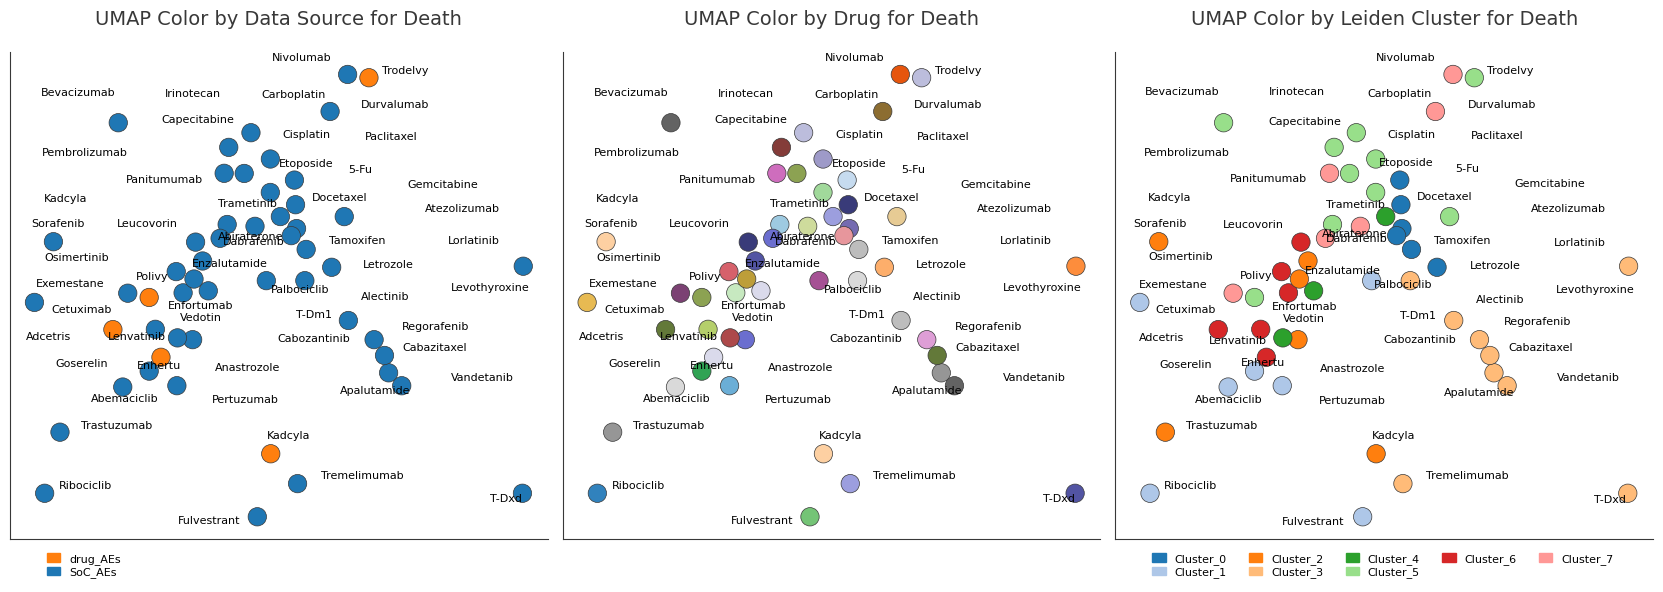

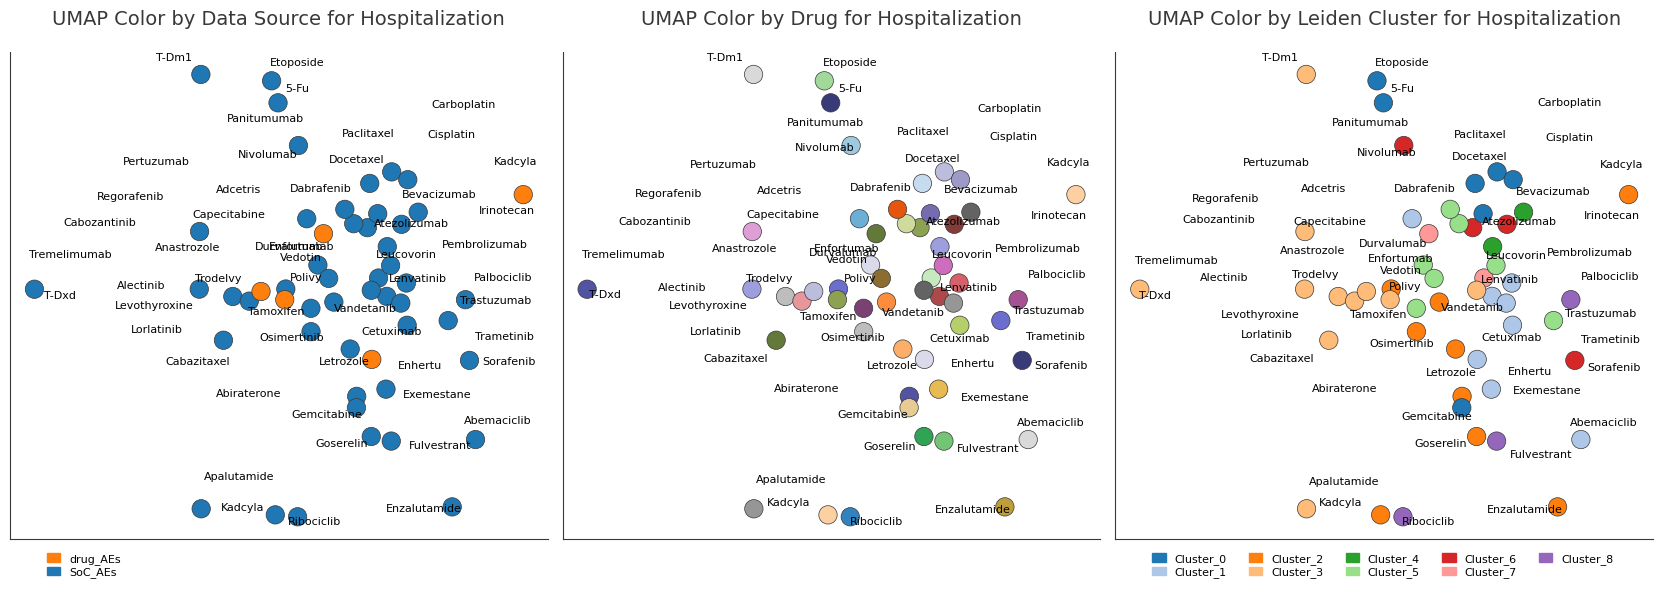

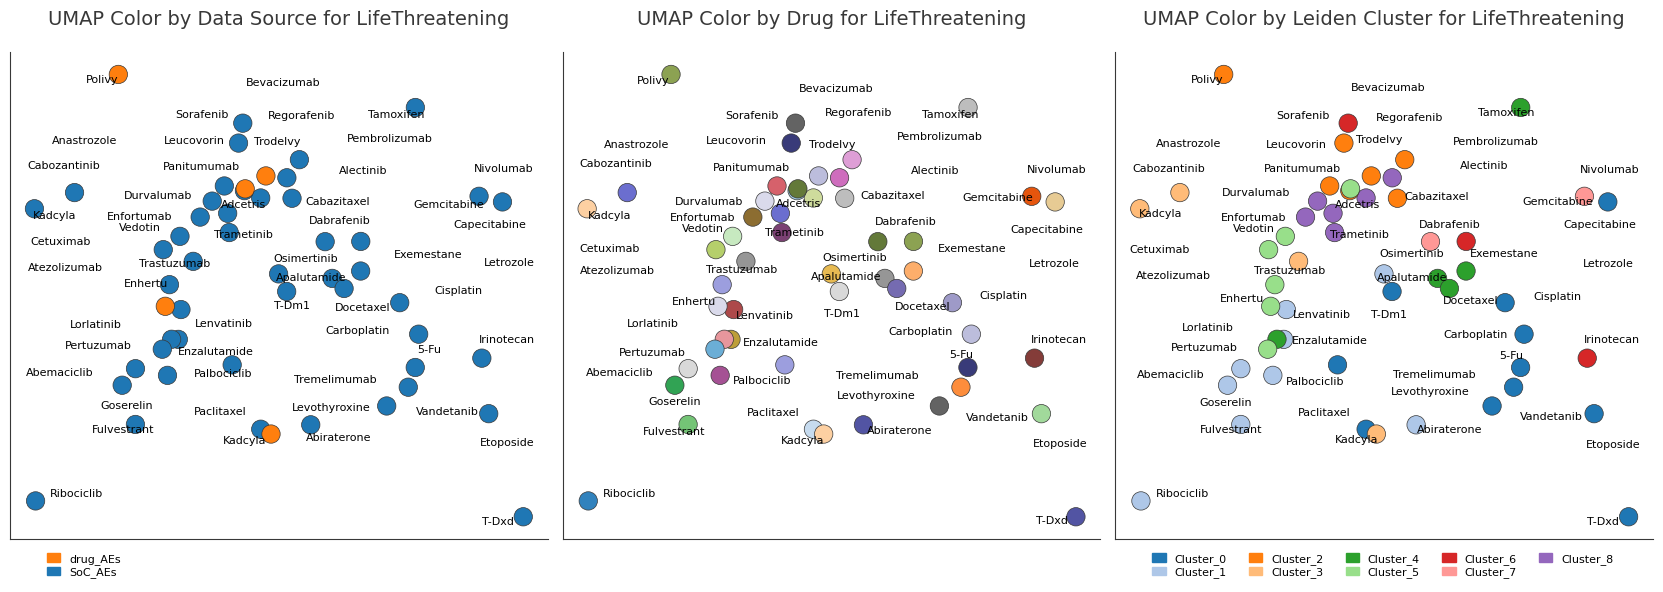

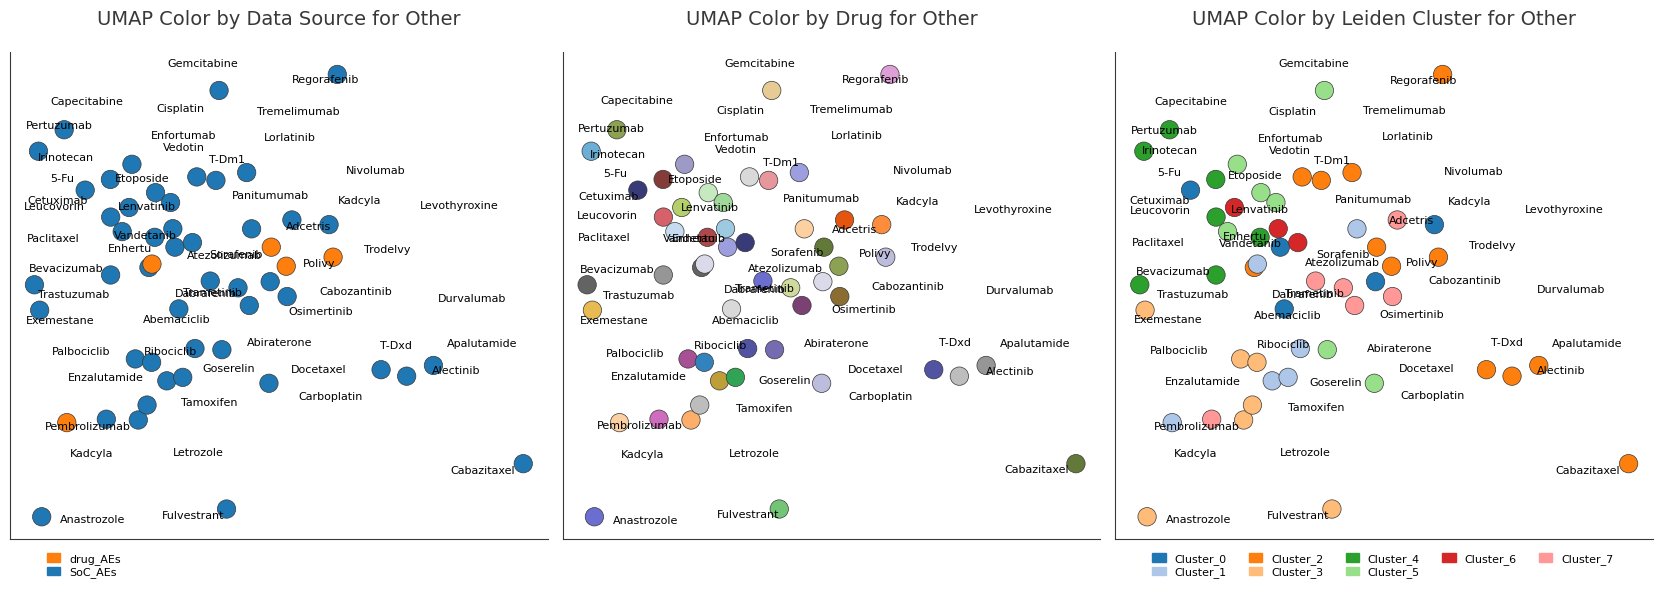

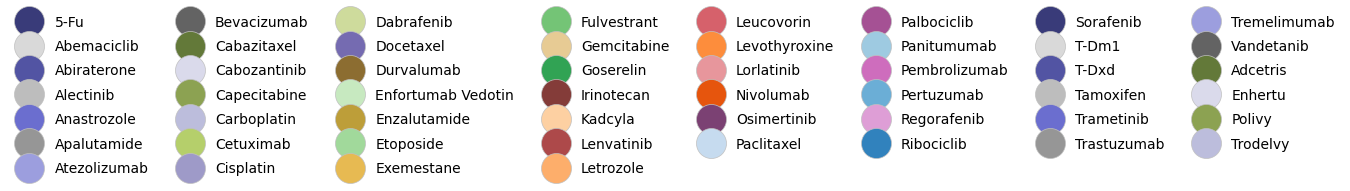

In [18]:
adata_main = None
for seriousness in seriousness_list:
    pivot_df = df_concat_2.pivot_table(index=['data_source', 'Drug_Name'], columns='Adverse_Event', values=seriousness, aggfunc='sum', fill_value=0)
    pivot_df = pivot_df.reset_index()
    pivot_df.index.name = None
    pivot_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_df.columns]
    #print(len(pivot_df)); pivot_df.head(3)
    drug_names = pivot_df[['data_source', 'Drug_Name']]
    drug_names.sample(3)
    pivot_df2 = pivot_df.drop(columns=['data_source', 'Drug_Name'])
    #print(len(pivot_df2)); pivot_df2.head(3)
    # Keep a numeric-only version
    df_numeric = pivot_df2.select_dtypes(include='number').copy()                   # Keep a numeric-only version
    df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce', downcast='float')
    pivot_df.index   = pivot_df2.index.astype(str)
    df_numeric.index = df_numeric.index.astype(str)
    #print(df_numeric.shape); print(df_numeric.max().max())
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #         .         .         .         .         .         .         .         .         .         .         .
        with open(os.devnull, "w") as fnull, contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            from anndata._core.aligned_df import ImplicitModificationWarning
            warnings.simplefilter("ignore", ImplicitModificationWarning)
            #         .         .         .         .         .         .         .         .         .         .         .
            df_numeric = pivot_df2.select_dtypes(include='number').copy()        # Flatten MultiIndex if present and reset index
            if isinstance(df_numeric.index, pd.MultiIndex):
                df_numeric = df_numeric.reset_index(drop=True)
            #         .         .         .         .         .         .         .         .         .         .         .
            pivot_df = pivot_df.reset_index(drop=True)                           # Reset index on pivot_df to ensure alignment
            #         .         .         .         .         .         .         .         .         .         .         .
            adata_temp = sc.AnnData(df_numeric)                                  # Create AnnData object
            
            adata_temp.obs['Drug_Name']   = pivot_df['Drug_Name'].values
            adata_temp.obs['data_source'] = pivot_df['data_source'].values
            adata_temp.obs["Seriousness"] = seriousness
            #         .         .         .         .         .         .         .         .         .         .         .
            sc.pp.pca(adata_temp); sc.pp.neighbors(adata_temp)
            sc.tl.leiden(adata_temp, random_state=42, resolution=resolution, key_added = "Leiden", 
                         flavor="igraph", n_iterations=n_iterations, directed=False)
            sc.tl.umap(adata_temp)
            #         .         .         .         .         .         .         .         .         .         .         .           
            cluster_col = "Leiden"
            adata_temp.obs[cluster_col] = adata_temp.obs["Leiden"].values
            #         .         .         .         .         .         .         .         .         .         .         .         
            if adata_main is None:
                adata_main = adata_temp.copy()
                if "X_umap" in adata_temp.obsm:
                    adata_main.obsm["X_umap"] = adata_temp.obsm["X_umap"]
            else:
                adata_main = ad.concat([adata_main, adata_temp], axis=0, join='outer', merge='same')
                if "X_umap" in adata_temp.obsm:
                    # Ensure that the number of observations (cells) matches
                    if adata_main.shape[0] == adata_temp.shape[0]:  # Check if the number of rows (observations) are equal
                        if "X_umap" in adata_main.obsm:
                            adata_main.obsm["X_umap"] = np.vstack([adata_main.obsm["X_umap"], adata_temp.obsm["X_umap"]])
                        else:
                            adata_main.obsm["X_umap"] = adata_temp.obsm["X_umap"]
                    else:
                        # Handle the case where the dimensions do not match (optional)
                        print(f"Warning: UMAP coordinates have mismatched dimensions: {adata_main.shape[0]} != {adata_temp.shape[0]}")
                        # Optionally recompute UMAP for adata_main or adata_temp here  
            #         .         .         .         .         .         .         .         .         .         .         .
            plot_umap_triple(adata_temp, seriousness)

In [19]:
adata_main

AnnData object with n_obs × n_vars = 212 × 11286
    obs: 'Drug_Name', 'data_source', 'Seriousness', 'Leiden'
    obsm: 'X_pca', 'X_umap'

In [25]:
df = adata_main.obs[['Drug_Name', 'data_source', 'Seriousness', 'Leiden']].copy()
df[['UMAP1', 'UMAP2']] = adata_main.obsm['X_umap']
df.sample(3)

,Drug_Name,data_source,Seriousness,Leiden,UMAP1,UMAP2
22,Gemcitabine,SoC_AEs,Hospitalization,0,-0.54,4.28
1,Abemaciclib,SoC_AEs,Other,0,22.97,4.18
23,Goserelin,SoC_AEs,Hospitalization,2,-2.20,7.04


In [27]:
df.to_csv("./data/UMAP_Analysis.csv", index=False)
#agg_reset.to_csv("./data/standard_of_care.csv", index=False)

In [21]:
seriousness_names_list = df['Seriousness'].unique().tolist()
seriousness_names_word_list =  ", ".join(sorted(seriousness_names_list));  
print("\n",len(seriousness_names_list))
print('\n\033[32m', seriousness_names_word_list, '\033[0m\n')


 4

 Death, Hospitalization, LifeThreatening, Other 



In [22]:
# Path to your audio file
audio_file = "./data/clock-chime-88027.mp3"
display(Audio(audio_file, autoplay=True))

In [23]:
elapsed_time = time.time() - start
minutes, seconds = divmod(elapsed_time, 60)
print("'03_openFDA_UMAP_v01' script run time:", f"{int(minutes)} min {int(seconds)} sec.")

'03_openFDA_UMAP_v01' script run time: 1 min 16 sec.
